<a href="https://colab.research.google.com/github/JuanManiglia/Guia_Tensorflow_Keras/blob/main/Clase_07/clase_07_3_latent_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modulo 7 : GANs**
* Instructor: [Juan Maniglia](https://juanmaniglia.github.io)

# Google CoLab Instructions


In [2]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Con Google CoLab")
except:
    print("Sin Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Con Google CoLab


# Modulo 7.3: Explorando el Vector Latente de StyleGAN

Las semillas StyleGAN, como la 3000, son solo semillas de números aleatorios que se utilizan para generar vectores latentes mucho más largos de 512 longitudes, que crean la imagen GAN. Si realiza un pequeño cambio en la semilla, por ejemplo, cambia 3000 a 3001, StyleGAN creará una imagen completamente diferente. Sin embargo, si realiza un pequeño cambio en algunos valores vectoriales latentes, la imagen solo cambiará ligeramente. En esta parte, veremos cómo podemos ajustar el vector latente para controlar, hasta cierto punto, la apariencia de la imagen GAN resultante.

In [3]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.17 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 3.8 MB/s eta 0:00:00


Usaremos las mismas funciones presentadas en la parte anterior para generar semillas e imágenes GAN.

In [4]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

A continuación, cargamos la GAN NVIDIA FFHQ (caras). Podríamos usar cualquier red GAN preentrenada de StyleGAN.

In [5]:
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print('Loading networks from "%s"...' % URL)
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


# Generar y ver GANS a partir de semillas

Comenzaremos generando algunas semillas para evaluar posibles puntos de partida para nuestro ajuste fino. Pruebe diferentes rangos de semillas hasta que tenga una semilla que se parezca a lo que desea ajustar.

Seed 4089


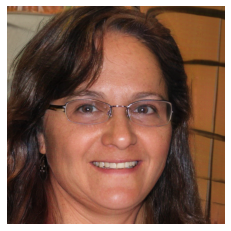

Seed 4090


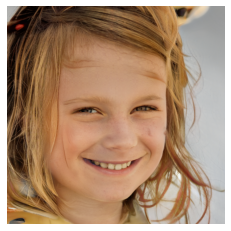

Seed 4091


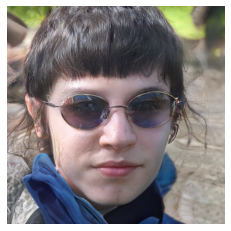

Seed 4092


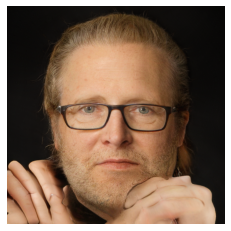

In [11]:
# Choose your own starting and ending seed.
SEED_FROM = 4089
SEED_TO = 4093
SEEDS  = range(SEED_FROM, SEED_TO)

# Generate the images for the seeds.
store_images = []
for i in SEEDS:
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  store_images.append((G,z,img))
  display_image(img)

In [17]:


from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)
STEPS = 100
# Genere las imágenes para el video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = store_images[i][1]
  v2 = store_images[i+1][1]

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Vincula las imágenes en un video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

Seed 4089:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 4090:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 4091:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

# Afinar una imagen

Si encuentra una semilla que le gusta, puede ajustarla ajustando directamente el vector latente. Primero, elige la semilla para afinar.

In [18]:
START_SEED = 4093

current = seed2vec(G, START_SEED)

In [22]:
current.shape

(1, 512)

A continuación, genere y visualice el vector actual. Volverá a este punto para cada iteración del ajuste.

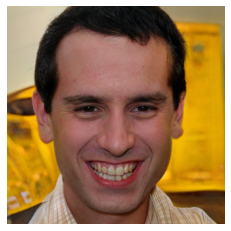

In [23]:
img = generate_image(device, G, current)

SCALE = 0.5
display_image(img)

Elija un tamaño de exploración; este es el número de imágenes potenciales diferentes que se elegirán moviéndose en 10 direcciones diferentes. Ejecute este código una vez inicialmente y luego otra vez cada vez que desee cambiar las diez direcciones que está explorando. Puede cambiar las diez direcciones si ya no ve mejoras.

In [24]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

In [27]:
print(explore[0])

[[-0.1874146  -0.36799839 -0.21743104 -0.48561906  0.12532308 -0.46287865
   0.46989388 -0.23002396 -0.48888855  0.23285564  0.0182748  -0.1212359
   0.01166671 -0.25187911 -0.11519955 -0.16423781 -0.09296269  0.0576344
  -0.39385931 -0.2315418  -0.39747097  0.47656426 -0.39988532  0.05476818
   0.33665462  0.13932102 -0.00421453  0.26212055 -0.46513379  0.27645455
   0.00970072 -0.28154204 -0.16611556  0.34364019  0.40284536  0.46402091
   0.21523895  0.38043722  0.35127885 -0.289994   -0.42171711  0.39828804
  -0.00891952  0.4969404  -0.45907099 -0.1990412   0.43880093 -0.07655646
   0.17645455 -0.04580639  0.15294181 -0.32036305  0.49564379  0.13654523
   0.00884057 -0.33389013  0.36539607  0.04475993 -0.28549814 -0.270634
  -0.47983016  0.40904585  0.40350164 -0.37602437 -0.25520453 -0.03157928
   0.24582425  0.03858324 -0.27765387  0.32682781 -0.00890297  0.15277004
  -0.45574316  0.17774275  0.17125957 -0.39918548 -0.45117883  0.30697286
  -0.20261634  0.11087161  0.30300508 -0.2

Cada imagen que se muestra al ejecutar este código muestra una dirección potencial en la que podemos movernos en el vector latente. Elige una imagen que te guste y cambia MOVE_DIRECTION para indicar esta decisión. Una vez que vuelva a ejecutar el código, el código le dará un nuevo conjunto de direcciones potenciales. Continúe este proceso hasta que tenga un vector latente que le guste.

Direction 0


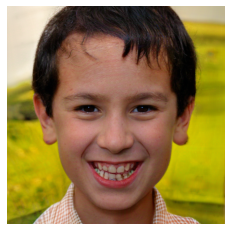

Direction 1


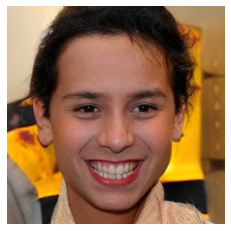

Direction 2


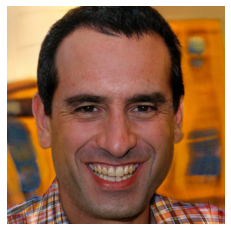

Direction 3


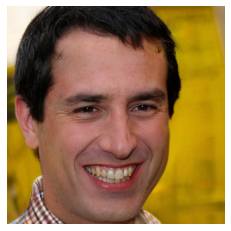

Direction 4


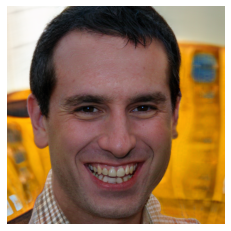

Direction 5


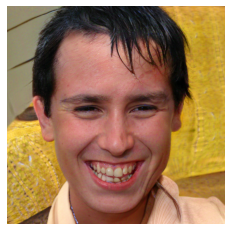

Direction 6


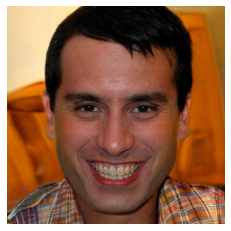

Direction 7


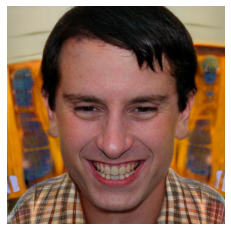

Direction 8


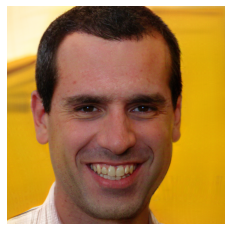

Direction 9


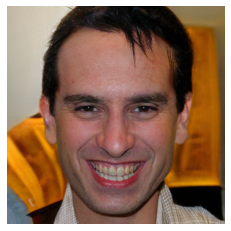

Direction 10


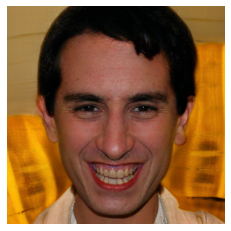

Direction 11


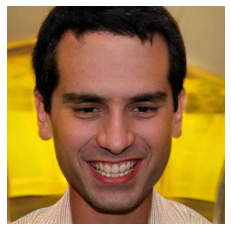

Direction 12


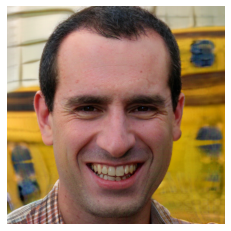

Direction 13


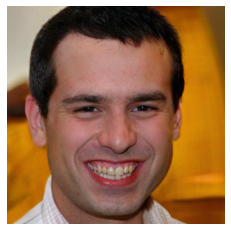

Direction 14


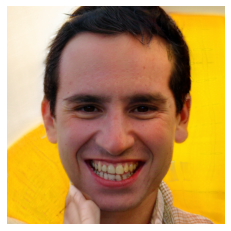

Direction 15


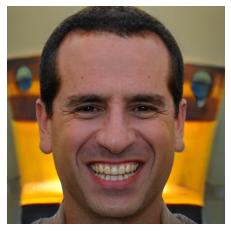

Direction 16


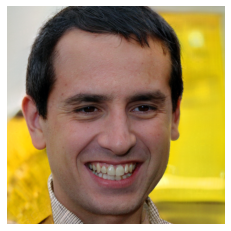

Direction 17


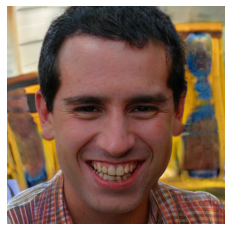

Direction 18


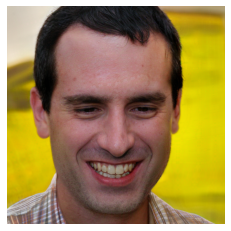

Direction 19


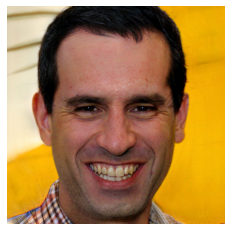

Direction 20


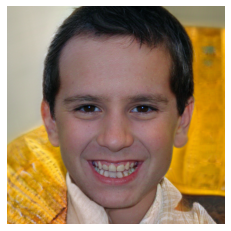

Direction 21


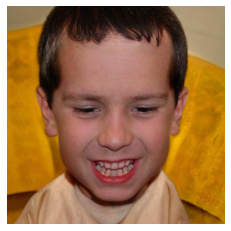

Direction 22


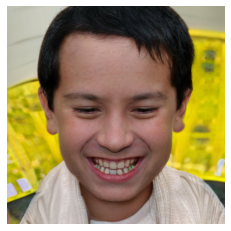

Direction 23


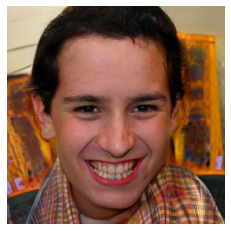

Direction 24


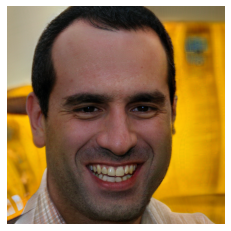

In [25]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  z = current + mv 
  img = generate_image(device, G, z)
  display_image(img)